In [9]:
# -------------------------------------------------------------------
# CELL 1: SETUP AND IMPORTS
# -------------------------------------------------------------------
print("Cell 1: Setting up and importing libraries...")

!pip install sentence-transformers tqdm numpy Pillow torch torchvision matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import json
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

print("✅ Cell 1: Complete")


Cell 1: Setting up and importing libraries...
✅ Cell 1: Complete


In [10]:
# -------------------------------------------------------------------
# CELL 2: MODEL DEFINITIONS
# -------------------------------------------------------------------
print("\nCell 2: Defining all model architectures...")

# --- Sinusoidal Time Embeddings ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

# --- Autoencoder ---
class Encoder(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, latent_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(base_channels * 4, latent_channels, 3, 1, 1),
        )

    def forward(self, x): return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, out_channels=3, base_channels=64, latent_channels=4):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, base_channels * 4, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(base_channels, out_channels, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z): return self.decoder(z)

# --- U-Net Blocks ---
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=256, condition_dim=384):
        super().__init__()
        self.time_emb_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )
        self.condition_mlp = nn.Sequential(
            nn.Linear(condition_dim, time_dim), nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )
        self.down1 = ConvBlock(in_channels, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up1 = ConvBlock(256 + 128, 128)
        self.up2 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, out_channels, 1, 1)

    def forward(self, x, t, condition):
        t_emb = self.time_emb_mlp(t)
        c_emb = self.condition_mlp(condition)
        emb = t_emb + c_emb
        x1 = self.down1(x)
        x2 = F.max_pool2d(x1, 2)
        x3 = self.down2(x2)
        x4 = F.max_pool2d(x3, 2)
        x5 = self.bot1(x4)
        x5 = x5 + emb.view(emb.shape[0], emb.shape[1], 1, 1)
        x = F.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.up1(torch.cat([x, x3], dim=1))
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.up2(torch.cat([x, x1], dim=1))
        return self.out(x)

# --- Text Embedder ---
class SentenceTransformerEmbedder:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.model = SentenceTransformer(model_name, device=device)
        self.embedding_dim = self.model.get_sentence_embedding_dimension()

    def _triplets_to_text(self, triplets):
        return ". ".join([f"{s.replace('_', ' ')} {r.replace('_', ' ')} {o.replace('_', ' ')}" for s, r, o in triplets]) + "."

    def embed_scene(self, triplets):
        if not triplets: return np.zeros(self.embedding_dim)
        return self.model.encode(self._triplets_to_text(triplets), convert_to_tensor=False)

print("✅ Cell 2: Complete")



Cell 2: Defining all model architectures...
✅ Cell 2: Complete


In [21]:
# -------------------------------------------------------------------
# CELL 3: CONFIGURATION AND DATASET
# -------------------------------------------------------------------
print("\nCell 3: Setting up configuration and data pipeline...")

# --- Config ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR_IMAGES = 'recolored_images/'
DATA_DIR_TOKENS = 'layout_tokens/'
IMAGE_SIZE = 1024
BATCH_SIZE = 1
TIMESTEPS = 500
TIME_EMB_DIM = 256
LATENT_CHANNELS = 4
BASE_CHANNELS = 32

ENCODER_PATH = 'checkpoints/checkpoints/latent_sweep/latent4_base32_lossL1_img1024/encoder_final.pt'
DECODER_PATH = 'checkpoints/checkpoints/latent_sweep/latent4_base32_lossL1_img1024/decoder_final.pt'

# --- Dataset ---
class ImageEmbeddingDataset(Dataset):
    def __init__(self, image_dir, token_dir, embedder, image_size=256):
        self.image_dir = image_dir
        self.token_dir = token_dir
        self.embedder = embedder
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        all_files = os.listdir(image_dir)
        image_files = {f for f in all_files if f.lower().endswith(('_image.png', '_image.jpg', '_image.jpeg'))}
        image_ids = {f.rsplit('_image.', 1)[0] for f in image_files}

        self.valid_ids = [img_id for img_id in image_ids
                          if os.path.exists(os.path.join(token_dir, img_id + '_tokens.json'))]

        if not self.valid_ids:
            print("WARNING: No matching image-token pairs found.")
        else:
            print(f"Found {len(self.valid_ids)} matching image-token pairs.")

    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        item_id = self.valid_ids[idx]

        img_path = next(os.path.join(self.image_dir, item_id + ext)
                        for ext in ['_image.png', '_image.jpg', '_image.jpeg']
                        if os.path.exists(os.path.join(self.image_dir, item_id + ext)))

        image = Image.open(img_path).convert('RGB')
        image_tensor = self.transform(image)

        json_path = os.path.join(self.token_dir, item_id + '_tokens.json')
        with open(json_path, 'r') as f:
            triplets = [t for t in json.load(f) if isinstance(t, list) and len(t) == 3]

        embedding = self.embedder.embed_scene(triplets)

        return image_tensor, torch.from_numpy(embedding).float()

print("✅ Cell 3: Complete")



Cell 3: Setting up configuration and data pipeline...
✅ Cell 3: Complete


In [23]:
# -------------------------------------------------------------------
# CELL 4: INITIALIZE AND LOAD MODELS
# -------------------------------------------------------------------
print("\nCell 4: Initializing and loading models...")

# --- Text Embedder ---
embedder = SentenceTransformerEmbedder(device=DEVICE)

# --- Autoencoder ---
encoder = Encoder(latent_channels=LATENT_CHANNELS, base_channels=BASE_CHANNELS).to(DEVICE)
decoder = Decoder(latent_channels=LATENT_CHANNELS, base_channels=BASE_CHANNELS).to(DEVICE)

try:
    encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
    decoder.load_state_dict(torch.load(DECODER_PATH, map_location=DEVICE))
    encoder.eval(); decoder.eval()
    print("✅ Autoencoder models loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load autoencoder models: {e}")

# --- U-Net ---
CONDITION_DIM = embedder.embedding_dim
unet = UNet(
    in_channels=LATENT_CHANNELS,
    out_channels=LATENT_CHANNELS,
    time_dim=TIME_EMB_DIM,
    condition_dim=CONDITION_DIM
).to(DEVICE)

# --- Dataloader ---
if not os.path.exists(DATA_DIR_IMAGES):
    os.makedirs(DATA_DIR_IMAGES)
    Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='red').save(os.path.join(DATA_DIR_IMAGES, '0_image.png'))
    with open(os.path.join(DATA_DIR_TOKENS, '0_tokens.json'), 'w') as f:
        json.dump([["a", "b", "c"]], f)

dataset = ImageEmbeddingDataset(DATA_DIR_IMAGES, DATA_DIR_TOKENS, embedder, image_size=IMAGE_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) if len(dataset) > 0 else None

print("✅ Cell 4: Complete")



Cell 4: Initializing and loading models...
✅ Autoencoder models loaded successfully.
Found 1372 matching image-token pairs.
✅ Cell 4: Complete


In [24]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def get_noisy_latent(x_start, t, betas):
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    t = torch.clamp(t, 0, len(betas) - 1)
    sqrt_alpha = torch.sqrt(alphas_cumprod[t]).to(x_start.device)[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1. - alphas_cumprod[t]).to(x_start.device)[:, None, None, None]
    noise = torch.randn_like(x_start)
    return sqrt_alpha * x_start + sqrt_one_minus * noise, noise

def show_img(ax, tensor, title):
    ax.imshow(tensor.detach().cpu().clamp(0, 1))
    ax.set_title(title)
    ax.axis('off')


C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


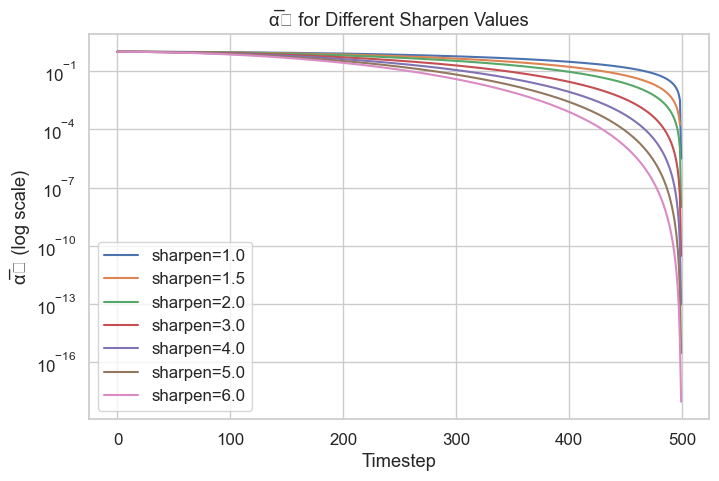

In [25]:
def make_cosine_betas(timesteps, s=0.008, sharpen=1.0):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    f = torch.cos(((x / timesteps + s) / (1 + s)) * math.pi / 2)
    alphas_cumprod = f ** sharpen
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.999)

import matplotlib.pyplot as plt

sharpen_values = [1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]
TIMESTEPS = 500

plt.figure(figsize=(8, 5))
for sharpen in sharpen_values:
    betas = make_cosine_betas(TIMESTEPS, s=0.008, sharpen=sharpen)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    plt.plot(alphas_cumprod.cpu().numpy(), label=f'sharpen={sharpen}')

plt.yscale('log')
plt.title("α̅ₜ for Different Sharpen Values")
plt.xlabel("Timestep")
plt.ylabel("α̅ₜ (log scale)")
plt.legend()
plt.grid(True)
plt.show()



Cell 5: Unified sweep with Seaborn-enhanced visuals...


c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\notebook-env\Lib\site-packages\torch\nn\modules\module.py:1527: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


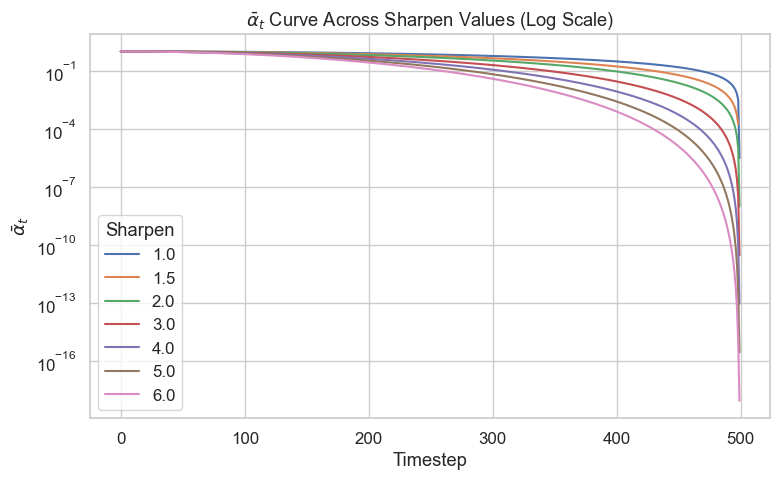

c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\notebook-env\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


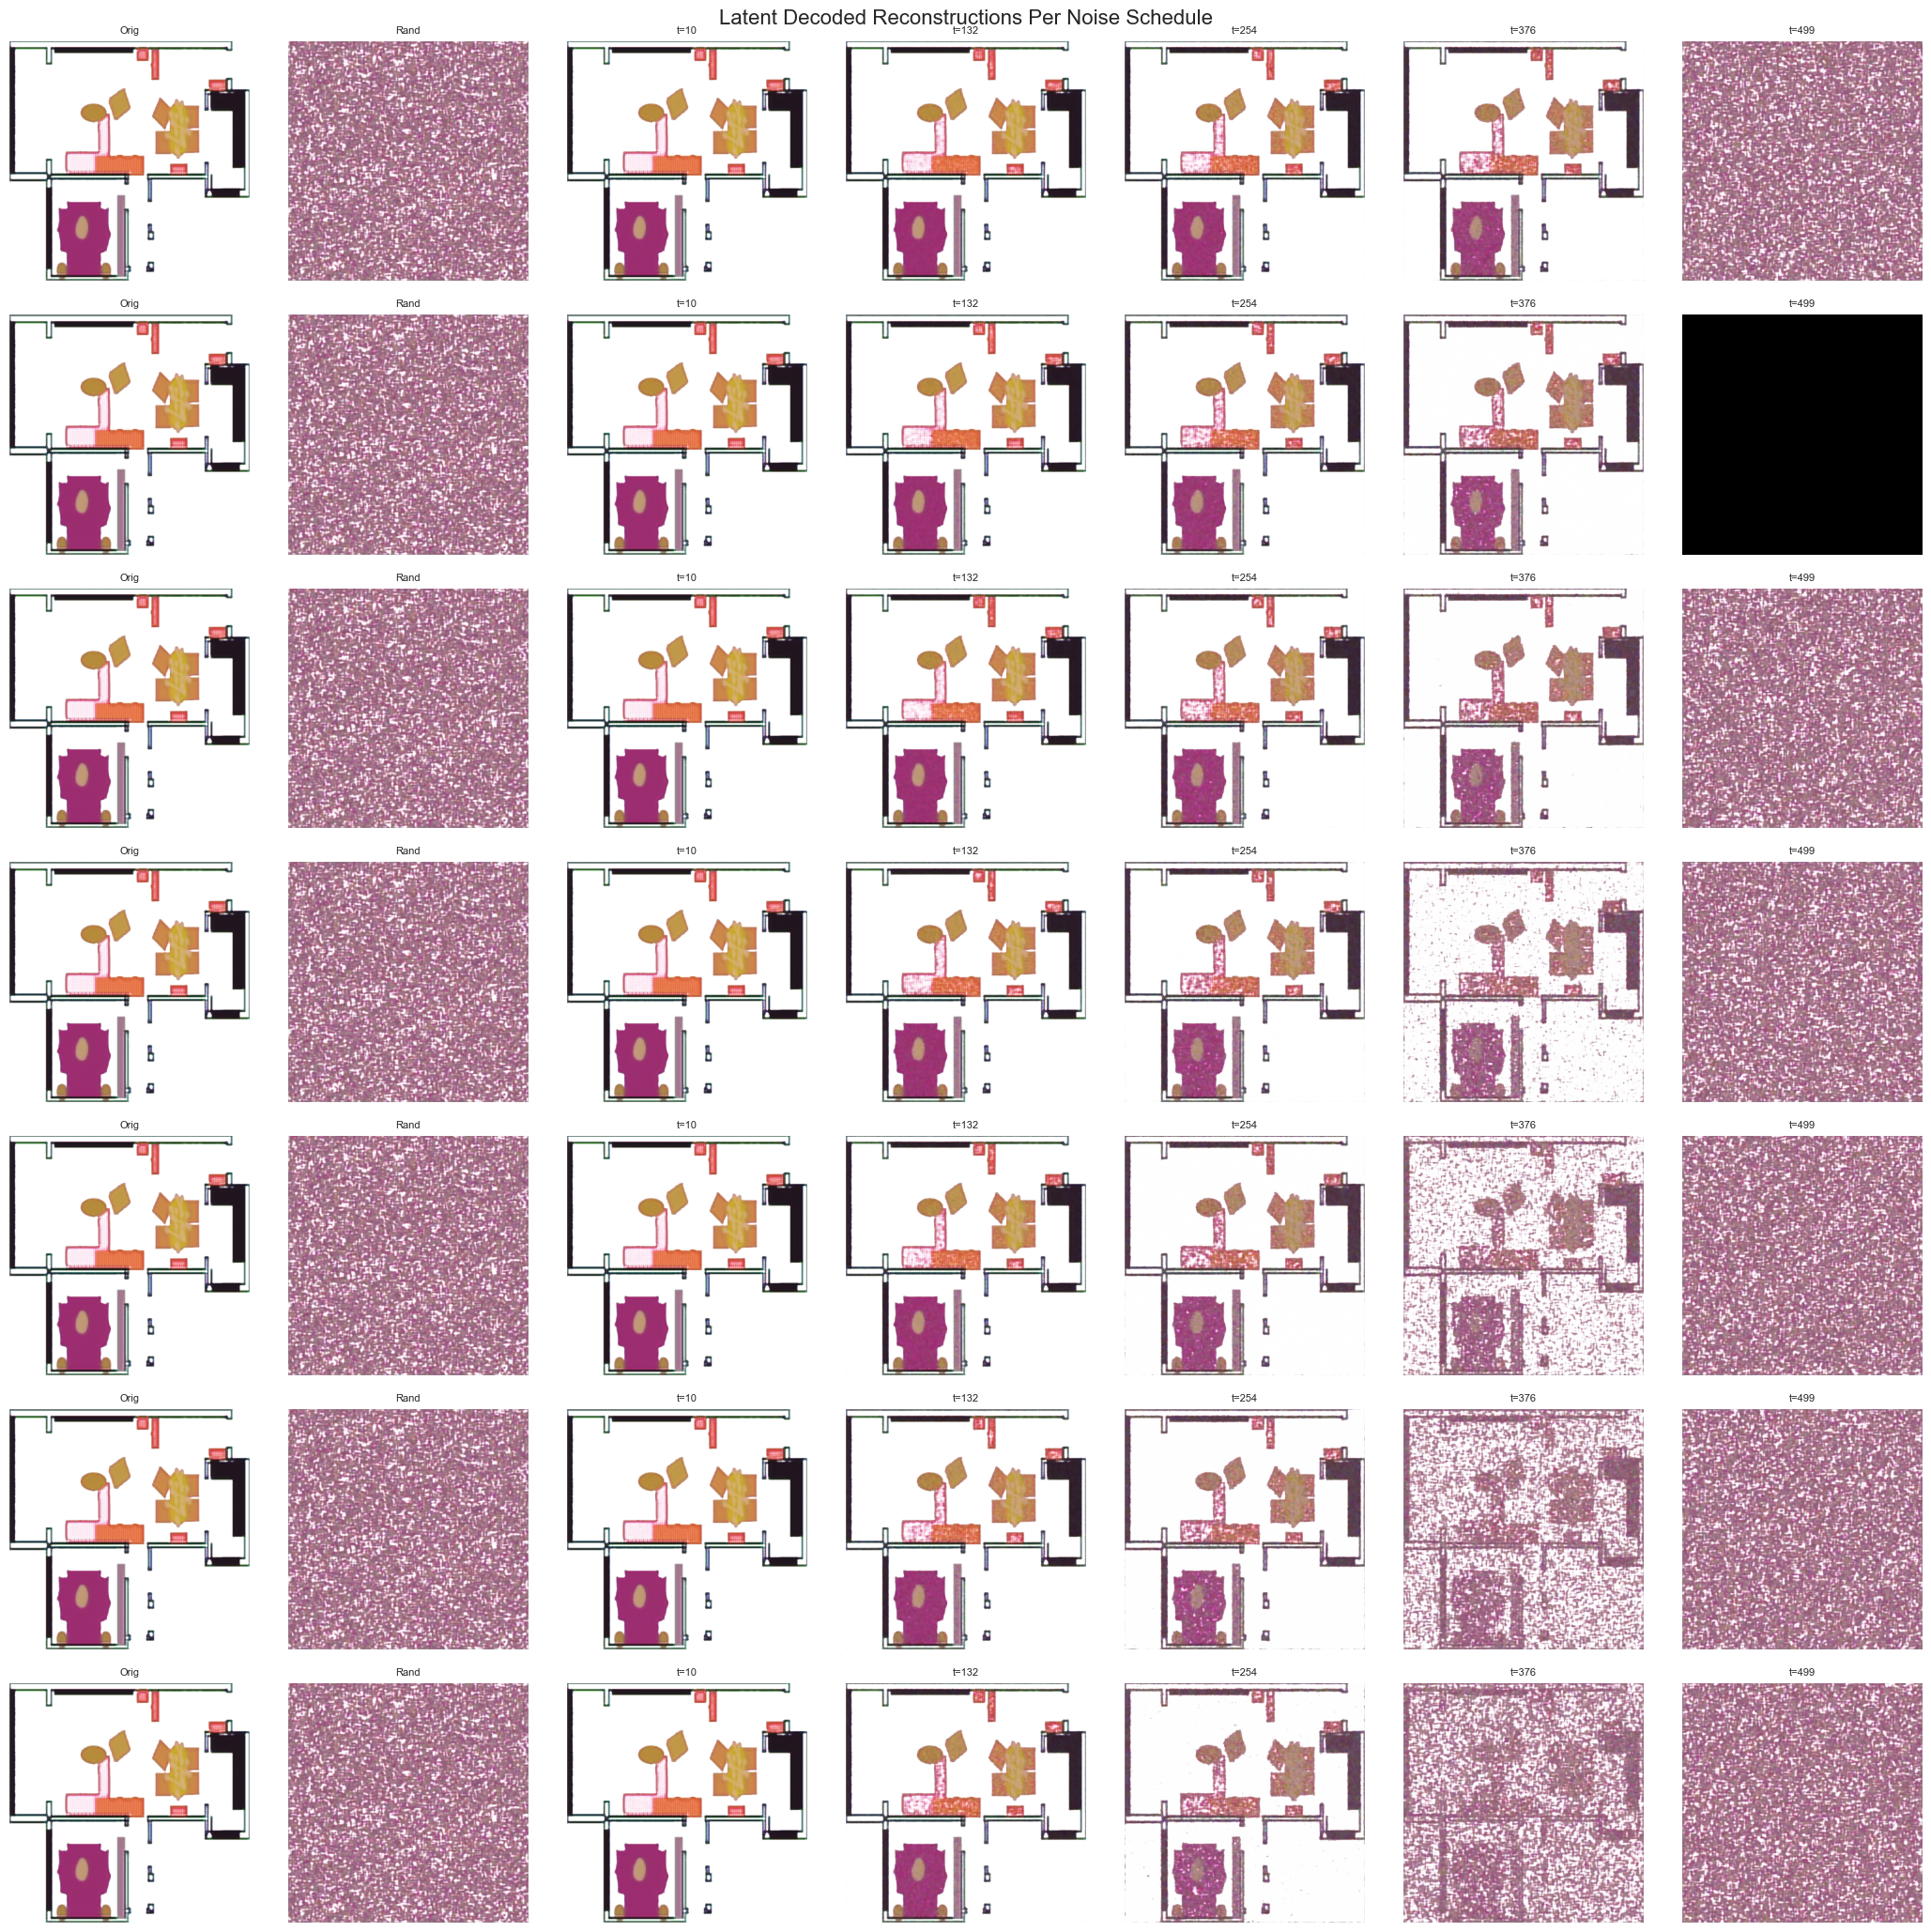

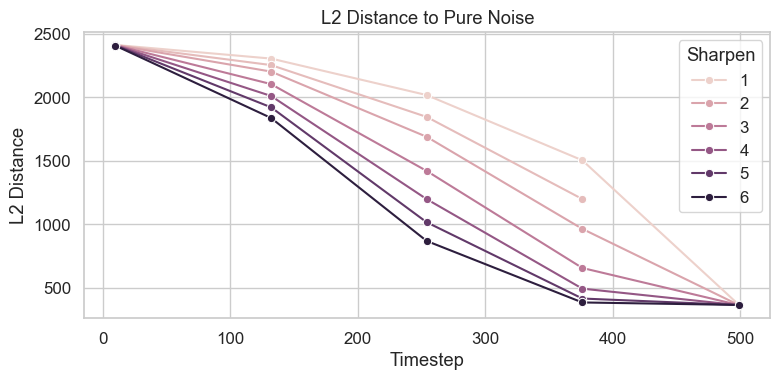

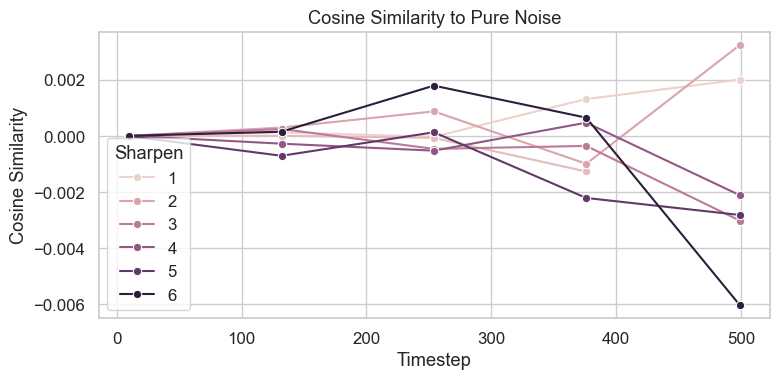

In [26]:
# -------------------------------------------------------------------
# CELL 5: SHARPEN SWEEP WITH SEABORN VISUALS
# -------------------------------------------------------------------
print("\nCell 5: Unified sweep with Seaborn-enhanced visuals...")
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.1)

def make_cosine_betas(timesteps, s=0.008, sharpen=1.0):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    f = torch.cos(((x / timesteps + s) / (1 + s)) * math.pi / 2)
    alphas_cumprod = f ** sharpen
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.999)

def get_noisy_latent(x_start, t, betas):
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    t = torch.clamp(t, 0, len(betas) - 1)
    sqrt_alpha = torch.sqrt(alphas_cumprod[t]).to(x_start.device)[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1. - alphas_cumprod[t]).to(x_start.device)[:, None, None, None]
    noise = torch.randn_like(x_start)
    return sqrt_alpha * x_start + sqrt_one_minus * noise, noise

def show_img(ax, tensor, title):
    ax.imshow(tensor.detach().cpu().clamp(0, 1))
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# --- Setup ---

t_values = np.floor(np.linspace(10, TIMESTEPS - 1, 5)).astype(int)

sample_image, _ = next(iter(dataloader))
sample_image = sample_image.to(DEVICE)
with torch.no_grad():
    latent_image = encoder(sample_image)
    pure_noise_latent = torch.randn_like(latent_image)
    recon_orig = (decoder(latent_image)[0].permute(1, 2, 0) + 1) / 2
    recon_rand = (decoder(pure_noise_latent)[0].permute(1, 2, 0) + 1) / 2

# --- α̅ₜ Curves (Seaborn) ---
alpha_data = []
for sharpen in sharpen_values:
    betas = make_cosine_betas(TIMESTEPS, s=0.008, sharpen=sharpen)
    alphas_cumprod = torch.cumprod(1. - betas, dim=0).cpu().numpy()
    for t, val in enumerate(alphas_cumprod):
        alpha_data.append({'Sharpen': sharpen, 'Timestep': t, 'AlphaCumprod': val})

alpha_df = pd.DataFrame(alpha_data)
plt.figure(figsize=(8, 5))
sns.lineplot(data=alpha_df, x='Timestep', y='AlphaCumprod', hue='Sharpen', palette='deep')
plt.yscale('log')
plt.title(r"$\bar{\alpha}_t$ Curve Across Sharpen Values (Log Scale)")
plt.ylabel(r"$\bar{\alpha}_t$")
plt.tight_layout()
plt.show()

# --- Reconstructions Grid ---
fig, ax = plt.subplots(len(sharpen_values), len(t_values) + 2, figsize=(3 * (len(t_values) + 2), 3 * len(sharpen_values)))
for row_idx, sharpen in enumerate(sharpen_values):
    betas = make_cosine_betas(TIMESTEPS, s=0.008, sharpen=sharpen)
    show_img(ax[row_idx, 0], recon_orig, "Orig")
    show_img(ax[row_idx, 1], recon_rand, "Rand")
    for col_idx, t_val in enumerate(t_values):
        t_tensor = torch.tensor([t_val] * BATCH_SIZE, device=DEVICE).long()
        noisy_latent, _ = get_noisy_latent(latent_image, t_tensor, betas)
        with torch.no_grad():
            recon = (decoder(noisy_latent)[0].permute(1, 2, 0).clamp(-1, 1) + 1) / 2
        show_img(ax[row_idx, col_idx + 2], recon, f"t={t_val}")
    ax[row_idx, 0].set_ylabel(f"Sharpen={sharpen}", fontsize=10)
plt.suptitle("Latent Decoded Reconstructions Per Noise Schedule", fontsize=16)
plt.tight_layout()
plt.show()

# --- Distance Metrics (Seaborn Line Plots) ---
distance_data = []
for sharpen in sharpen_values:
    betas = make_cosine_betas(TIMESTEPS, s=0.008, sharpen=sharpen)
    for t_val in t_values:
        t_tensor = torch.tensor([t_val] * BATCH_SIZE, device=DEVICE).long()
        noisy_latent, _ = get_noisy_latent(latent_image, t_tensor, betas)
        l2 = torch.norm(noisy_latent - pure_noise_latent).item()
        cos = F.cosine_similarity(noisy_latent.flatten(1), pure_noise_latent.flatten(1)).mean().item()
        distance_data.append({'Sharpen': sharpen, 'Timestep': t_val, 'L2': l2, 'CosineSimilarity': cos})

dist_df = pd.DataFrame(distance_data)

# L2 Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=dist_df, x='Timestep', y='L2', hue='Sharpen', marker='o')
plt.title("L2 Distance to Pure Noise")
plt.ylabel("L2 Distance")
plt.tight_layout()
plt.show()

# Cosine Similarity Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=dist_df, x='Timestep', y='CosineSimilarity', hue='Sharpen', marker='o')
plt.title("Cosine Similarity to Pure Noise")
plt.ylabel("Cosine Similarity")
plt.tight_layout()
plt.show()


In [27]:
# -------------------------------------------------------------------
# CELL 6: ONE-STEP PIPELINE TEST
# -------------------------------------------------------------------
print("\nCell 6: Running one-step pipeline test...")

if dataloader:
    optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    betas = linear_beta_schedule(TIMESTEPS).to(DEVICE)

    print("--- Verifying Pipeline with a Single Batch ---")
    try:
        images, conditions = next(iter(dataloader))
        images, conditions = images.to(DEVICE), conditions.to(DEVICE)

        with torch.no_grad():
            latents = encoder(images)

        t = torch.randint(0, TIMESTEPS, (images.shape[0],), device=DEVICE).long()
        noisy_latents, noise = get_noisy_latent(latents, t, betas)
        predicted_noise = unet(noisy_latents, t, conditions)

        loss = criterion(predicted_noise, noise)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        print(f"Image batch shape:     {images.shape}")
        print(f"Condition batch shape: {conditions.shape}")
        print(f"Latents shape:         {latents.shape}")
        print(f"Predicted noise shape: {predicted_noise.shape}")
        print(f"Calculated loss:       {loss.item():.4f}")
        print("\n✅ Pipeline test passed.")
    except Exception as e:
        import traceback
        print(f"\n❌ Error during pipeline test: {e}")
        traceback.print_exc()
else:
    print("Skipping test: no data available.")

print("✅ Cell 6: Complete")



Cell 6: Running one-step pipeline test...
--- Verifying Pipeline with a Single Batch ---


c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\notebook-env\Lib\site-packages\torch\nn\modules\module.py:1527: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Image batch shape:     torch.Size([1, 3, 1024, 1024])
Condition batch shape: torch.Size([1, 384])
Latents shape:         torch.Size([1, 4, 128, 128])
Predicted noise shape: torch.Size([1, 4, 128, 128])
Calculated loss:       1.1260

✅ Pipeline test passed.
✅ Cell 6: Complete
